### **Graph Data Project - ST459 - Adaptive Graph Neural Networks for Real-Time Financial Fraud Detection**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. In this project we will try to answer this questions :

How do Temporal Graph Convolutional Networks (T-GCNs) compare to static GNNs in terms of precision, recall, and inference latency?



### **Dataset and preparation of the data**

In [ ]:
!pip install torch_geometric
!pip install torchmetrics
!pip install pytorch-lightning
!pip install torch-geometric torch-geometric-temporal



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 832.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [34]:
#import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv


The dataset used is the : IEEE-CIS Fraud Detection Dataset(https://www.kaggle.com/competitions/ieee-fraud-detection/data)

For this analysis we are using only the dataset 'train_transaction' because we don't need the extra data that are in the other files.

In [ ]:
#read the file
df = pd.read_csv('train_transaction.csv')
#we chose what we take
df=df[:100000]
df = df[['isFraud', 'TransactionAmt','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']]

For our purpose we only take the first 100 000 lines and the 15 columns, where isFraud is 1 for a fraudulent transaction and 0 if it is not. Our goal is to predict of if a transaction is gonna be fraudulent on data that has not been seen. We only work with numerical variables.

## **Construct our static graph**
### **Baseline GCN**

 GCNs efficiently learn features and recognize patterns in financial data by capturing local connectivity and automatically discerning node and edge features. However, GCNs can suffer from over-smoothing, leading to the loss of distinct node characteristics, and are prone to overfitting with limited data.

 We will try to predict with a GCN if a transaction is fraudulent or not.

In [42]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from imblearn.over_sampling import SMOTE


In this part, we will split the data into train and test in order to evaluate our model performance.
We will also normalize the data because some features like 'TransactionAmt' have different scales compared to PCA-transformed features (C1 - C13). Normalizing ensures that each feature contributes equally to the model's learning process.

In [43]:
#seed
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# split the dataset
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 42)

#split into x and y for the training and test
X_train = df_train.iloc[:, :-1].values  #we want a numpy array instead of a panda dataframe
y_train = df_train['isFraud'].values

X_test = df_test.iloc[:, :-1].values
y_test = df_test['isFraud'].values

#normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)


(80000, 15)
(20000, 15)
(80000,)
(20000,)


In this section of the code we are transforming a tabular dataset into a graph structure suitable for GNN.

Each transaction is represented by a node and each
edge is between 2 nodes is based on features similarity using the k-neighbours algorithm.

We decided that our graph should be undirected because if a transaction happened between A and B it is likely to happen between B and A.


For the test data, we will construct a separate KNN-based graph - it ensures that the model evaluates each transaction in the context of its most similar counterparts within the test set, without relying on information from the training set.

In [44]:
n_neighborhod=5

#build an adjacaency matrix with the train data
knn_graph = kneighbors_graph(X_train_scaled, n_neighbors=n_neighborhod, metric='euclidean', include_self=False)
adj = knn_graph.tocoo() # adjacency matrix

#we create the edge indexes
row = torch.from_numpy(adj.row.astype(np.int64))
col = torch.from_numpy(adj.col.astype(np.int64))
edge_index = torch.stack([row, col], dim=0)  #shape = 2*number of edges  and in the 2 it is from the source node to the target node

# we make it undirected
edge_index = to_undirected(edge_index)

#transform in tensor
x = torch.tensor(X_train_scaled, dtype=torch.float) #feature matrix
y = torch.tensor(y_train, dtype=torch.long)#labels for each node

#geometric graph data that we can use y is the label, x is the feature matrix and edge index is the structure of the graph thta we built.
data_train = Data(x=x, edge_index=edge_index, y=y)
#  x= [num_nodes, num_features]
# edge index =[2, num_edges] based on feature similarity


#for test data
knn_graph_test = kneighbors_graph(X_test_scaled, n_neighbors=n_neighborhod, mode='connectivity', include_self=False)
adj_test = knn_graph_test.tocoo()

row1 = torch.from_numpy(adj_test.row.astype(np.int64))
col1 = torch.from_numpy(adj_test.col.astype(np.int64))
edge_index1 = torch.stack([row1, col1], dim=0)  #shape = 2*number of edges  and in the 2 it is from the source node to the target node
edge_index1 = to_undirected(edge_index1)
x1 = torch.tensor(X_test_scaled, dtype=torch.float) #feature matrix
y1 = torch.tensor(y_test, dtype=torch.long)#labels for each node
data_test = Data(x=x1, edge_index=edge_index1, y=y1)




In this part, we assigned masks like train_mask, val_mask, and test_mask in the context of graph-based data . The goal of this masks is to specify which nodes belong to each subset of the data (training, validation, or testing).

In [45]:

#we split the train into training amd validation
num_nodes = data_train.x.size(0)  #nb of nodes

#shuffle the index
indices = torch.randperm(num_nodes)
#split the data
train_size = int(0.80 * num_nodes)
val_size = int(0.2*num_nodes)

#create the train_mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[indices[:train_size]] = 1

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[indices[train_size:train_size + val_size]] = 1

#assign these masks to the data objects
data_train.train_mask = train_mask
data_train.val_mask = val_mask

#test mask for the test part
num_nodes_test = data_test.x.size(0)
test_mask = torch.ones(num_nodes_test, dtype=torch.bool)
data_test.test_mask = test_mask




In this part, with the data that we have prepared for a GNN, we are going to build a GCN - a widely used sort of GNN.

We chose a two-layer Graph Convolutional Network (GCN) using PyTorch Geometric because it is an effective model for the fraud detection task that we have to solve.


**1st layer  :**
input :
in_channels: Number of input features per node (15).
out_channels: Number of output features per node after the convolution (16).

**Relu and dropout**
Relu introduces non linear features
Dropout helps to prevent overfitting.

**2nd layer :**
input =  Number of output features per node after the 1st convolution layer (16)
output = 2 - binary classification

**Log softmax layer:**
It converts the raw scores inot probabilities.

In [46]:
import random
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

##gcn
class GCN(torch.nn.Module):

    #params initializer
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    #build the architecture
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5) #we onnly use the dropout for the training part
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(num_node_features=15, hidden_channels=16, num_classes=2)
print(model)


GCN(
  (conv1): GCNConv(15, 16)
  (conv2): GCNConv(16, 2)
)


We are going to train our simple GNN - we are going to use of the cross entropy loss and Adam optimizer. This time, we also define a test function to evaluate how well our final model performs on the test node set (which labels have not been observed during training).


The first function train the model over multiple epochs and backpropagate the gradient in order ot reduce the loss.

The second function is evaluating the data from the test dataset and calculate the accuracy.

Epoch: 001, Loss: 0.7385, Val Loss: 0.7433
Epoch: 002, Loss: 0.7194, Val Loss: 0.7214
Epoch: 003, Loss: 0.7198, Val Loss: 0.7217
Epoch: 004, Loss: 0.7138, Val Loss: 0.7153
Epoch: 005, Loss: 0.7073, Val Loss: 0.7096
Epoch: 006, Loss: 0.7007, Val Loss: 0.7044
Epoch: 007, Loss: 0.6901, Val Loss: 0.6938
Epoch: 008, Loss: 0.6817, Val Loss: 0.6819
Epoch: 009, Loss: 0.6832, Val Loss: 0.6861
Epoch: 010, Loss: 0.6699, Val Loss: 0.6730
Epoch: 011, Loss: 0.6624, Val Loss: 0.6654
Epoch: 012, Loss: 0.6494, Val Loss: 0.6520
Epoch: 013, Loss: 0.6478, Val Loss: 0.6504
Epoch: 014, Loss: 0.6401, Val Loss: 0.6399
Epoch: 015, Loss: 0.6383, Val Loss: 0.6417
Epoch: 016, Loss: 0.6261, Val Loss: 0.6328
Epoch: 017, Loss: 0.6158, Val Loss: 0.6213
Epoch: 018, Loss: 0.6182, Val Loss: 0.6209
Epoch: 019, Loss: 0.6077, Val Loss: 0.6105
Epoch: 020, Loss: 0.6027, Val Loss: 0.6075
Epoch: 021, Loss: 0.5989, Val Loss: 0.6030
Epoch: 022, Loss: 0.5901, Val Loss: 0.5910
Epoch: 023, Loss: 0.5852, Val Loss: 0.5898
Epoch: 024,

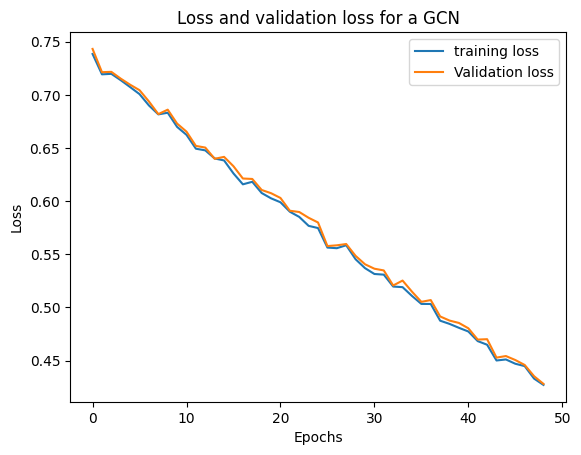

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

loss_train1 = []
val_loss_train1=[]
criterion = torch.nn.CrossEntropyLoss()  #loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  #optimizer

start_time1=time.time()


def train(model, optimizer, criterion, data_train):
    model.train()  #training model
    optimizer.zero_grad()  #claer gradient
    out = model(data_train)  #perform a forward pass using the entire data_train object
    loss = criterion(out[data_train.train_mask], data_train.y[data_train.train_mask])  #loss only on the training nodes
    val_loss = criterion(out[data_train.val_mask], data_train.y[data_train.val_mask])  #validation loss
    loss.backward()  #backpropagate to compute gradients
    optimizer.step()
    return loss.item(), val_loss.item()  #return loss for logging


def precision_recall(model, data_test):
    model.eval()
    with torch.no_grad():
        out = model(data_test)
        prob = torch.sigmoid(out)[:,1] #get the probabilities for the highest class
        pred = out.argmax(dim=1)
        y_true = data_test.y[data_test.test_mask].cpu().numpy()
        prob = prob[data_test.test_mask].cpu().numpy()
        y_pred = pred[data_test.test_mask].cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, prob)
        aupr = average_precision_score(y_true, prob)

    return precision, recall, aupr, f1

#training loop
for epoch in range (1,50) :
  loss, val_loss = train(model, optimizer, criterion, data_train)
  loss_train1.append(loss)
  val_loss_train1.append(val_loss)
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')


end_time1 = time.time()
#graph
plt.plot(loss_train1, label = 'training loss')
plt.plot(val_loss_train1, label='Validation loss')
plt.title('Loss and validation loss for a GCN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the epochs and the graph, we can see that the model tends to decrease over the number of epochs - it stabilizes itself around 0.01 after 100 epochs. The validation loss and the training loss behave similarily and so for we can say that the model doesn't overfit the data. The model is learning and improving over time. It is just a bit slow to converge.

After training the model, we can call the test function to see how well our model performed on unseen labels. Here, we are interested in the f1 score and the precision recall graph.

The f1 score is 0.4129
The training time is : 6.8106 seconds


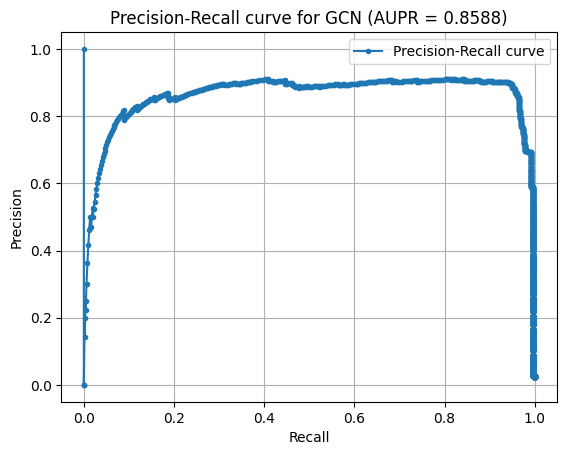

In [48]:
precision1, recall1, aupr1, f11 = precision_recall(model, data_test)
print(f"The f1 score is {f11:.4f}")
print(f"The training time is : {end_time1 - start_time1:.4f} seconds")


#graph
plt.plot(recall1, precision1, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve for GCN (AUPR = {aupr1:.4f})')
plt.legend()
plt.grid()
plt.show()


The F1 score is 0.42 which is not really  good but this why we are going to perform other graphs neural networks to see how well they perform. This low score means that model struggled to predict the minority class - here it is the fraudulent class. The training time is around 7 seconds which is really fast.

### **Baseline GAT : Graph Attention Network**


The attention mechanism is particularly useful in applications such as financial fraud detection.GATs should outperform GCNs by dynamically allocating attention weights to neighbors enabling adaptive focus on relevant nodes for improved complex pattern detection in financial fraud.

We implemented a GAT consisting of two layers of graph attention convolutions (GATConv). The first layer computes node representations using multi-head attention with 8 heads, followed by ReLU activation. The second layer reduces the dimensionality to the number of classes, applying a final attention mechanism, and the output is passed through log_softmax to get class probabilities for each node.

In [77]:

# Set seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels *8, num_classes, heads=1, dropout=0.6)

    def forward(self,data_train):
        x, edge_index = data_train.x, data_train.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)





model = GAT(num_node_features=15, hidden_channels=16, num_classes=2)
print(model)

GAT(
  (conv1): GATConv(15, 4, heads=2)
  (conv2): GATConv(8, 2, heads=1)
)


We are going to use the same function as the one that we used for the GNN classification.

Epoch: 001, Loss: 0.7494, Val Loss: 0.7490
Epoch: 002, Loss: 0.7174, Val Loss: 0.7113
Epoch: 003, Loss: 0.6796, Val Loss: 0.6774
Epoch: 004, Loss: 0.6487, Val Loss: 0.6499
Epoch: 005, Loss: 0.6215, Val Loss: 0.6209
Epoch: 006, Loss: 0.5919, Val Loss: 0.5941
Epoch: 007, Loss: 0.5630, Val Loss: 0.5651
Epoch: 008, Loss: 0.5404, Val Loss: 0.5424
Epoch: 009, Loss: 0.5163, Val Loss: 0.5158
Epoch: 010, Loss: 0.4921, Val Loss: 0.4924
Epoch: 011, Loss: 0.4673, Val Loss: 0.4693
Epoch: 012, Loss: 0.4460, Val Loss: 0.4453
Epoch: 013, Loss: 0.4237, Val Loss: 0.4224
Epoch: 014, Loss: 0.4013, Val Loss: 0.4025
Epoch: 015, Loss: 0.3812, Val Loss: 0.3800
Epoch: 016, Loss: 0.3603, Val Loss: 0.3599
Epoch: 017, Loss: 0.3399, Val Loss: 0.3417
Epoch: 018, Loss: 0.3210, Val Loss: 0.3206
Epoch: 019, Loss: 0.3036, Val Loss: 0.3042
Epoch: 020, Loss: 0.2865, Val Loss: 0.2855
Epoch: 021, Loss: 0.2696, Val Loss: 0.2687
Epoch: 022, Loss: 0.2543, Val Loss: 0.2544
Epoch: 023, Loss: 0.2423, Val Loss: 0.2411
Epoch: 024,

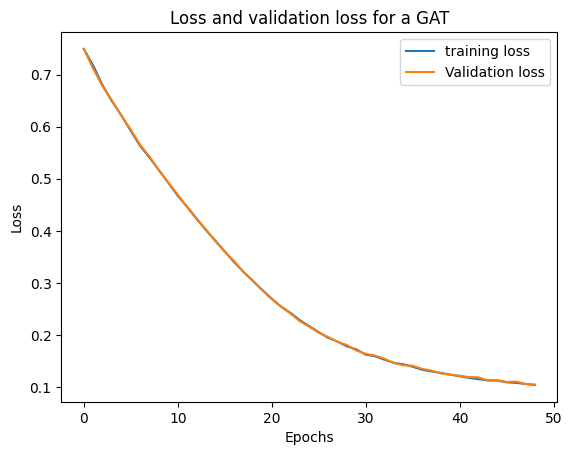

In [78]:

loss_train3 = []
val_loss_train3=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

start_time2=time.time()

def train(model, optimizer, criterion, data_train):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    loss = criterion(out[data_train.train_mask], data_train.y[data_train.train_mask])
    val_loss = criterion(out[data_train.val_mask], data_train.y[data_train.val_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), val_loss.item()


def precision_recall(model, data_test):
    model.eval()
    with torch.no_grad():
        out = model(data_test)
        prob = out.exp()[:,1]
        pred = out.argmax(dim=1)
        y_true = data_test.y[data_test.test_mask].cpu().numpy()
        prob = prob[data_test.test_mask].cpu().numpy()
        y_pred = pred[data_test.test_mask].cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, prob)
        aupr = average_precision_score(y_true, prob)

    return precision, recall, aupr, f1


for epoch in range (1,50) :
  loss, val_loss = train(model, optimizer, criterion, data_train)
  loss_train3.append(loss)
  val_loss_train3.append(val_loss)
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')


end_time2 = time.time()
#graph
plt.plot(loss_train3, label = 'training loss')
plt.plot(val_loss_train3, label='Validation loss')
plt.title('Loss and validation loss for a GAT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This model takes longer to compute, but we can see from the graph that actually it did perform well - it reaches a validation/training loss of almost 0.1 around 50 epochs. The validation loss curve behaves similarily as the training loss.

After training the model, we can call the test function to see how well our model performed on unseen labels.



The f1 score is 0.7970 
The training time is 9.1426 secondes


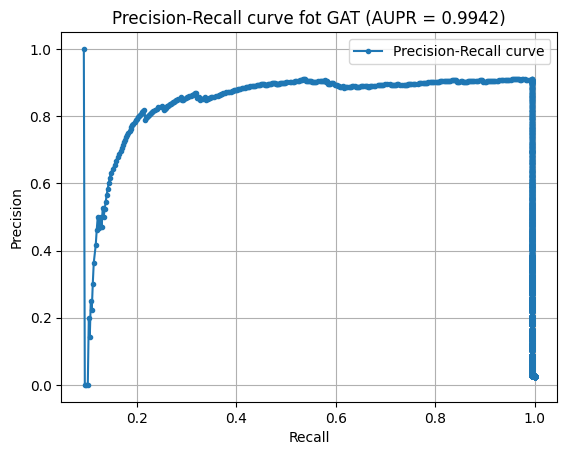

In [88]:
precision2, recall2, aupr2, f12 = precision_recall(model, data_test)
print(f"The f1 score is {f12:.4f} ")
print(f"The training time is {end_time2-start_time2:.4f} secondes")


#graph
plt.plot(recall2, precision2, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve fot GAT (AUPR = {aupr2:.4f})')
plt.legend()
plt.grid()
plt.show()

The F1 score is 0.76 which is a really high score meaning that the attention mechanism with the multihead helped the model to recognize the fraudulent class thanks to its coefficients. The training time is 9 secondes which is bit longer than the GCN, but it is still a reasonable time.

## **How do adaptive GNNs compare to static GNNs in terms of precision, recall, and inference latency?**


In this question, we will implemement a Temporal Graph Convolutional Network (TGCN) . We will use a aproximately the same architecture of Network in order to compare it with the GAT and the GCN

### **Temporal Graph Convolutional Network (TGCN)**



In [56]:
#import libraries
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import TGCN
from tqdm import tqdm
from imblearn.over_sampling import SMOTE


We will prepare the data for the temporal graph convolutional network.

We divide the dataset into smaller time steps or "snapshots," with each snapshot consisting of a fixed number of transactions (50 transactions).
For each snapshot, we create a graph where each transaction is represented as a node. The edges between these nodes are determined using a k-Nearest Neighbors (k-NN) approach. Transactions that are similar  are connected by edges. We use the connectivity mode of the k-NN graph to define these relationships. Additionally, each edge is assigned a weight which is mandatory for temporal graph.

In [58]:

#each transaction is a node
#slice the data into tme steps (ex:1000)
#Connect nodes using a k-NN graph (nodes are similar if their feature vectors are close)
#we add weight for the edges

#create temporal graphs
def create_temporal_graphs(X_data, y_data, num_snapshots=50, step_size=1000):
    snapshots = []

    for i in range(num_snapshots):
        start = i * step_size
        end = (i + 1) * step_size
        if end > len(X_data):
            break

        x = torch.FloatTensor(X_data[start:end])
        y_t = torch.FloatTensor(y_data[start:end])

        #KNN graph with connectivity as similarity measure
        A = kneighbors_graph(X_data[start:end], n_neighbors=5, mode='connectivity', include_self=False)
        edge_index = torch.LongTensor(np.vstack(A.nonzero()))
        edge_weight = torch.FloatTensor(np.ones(edge_index.shape[1]))

        snapshots.append((x, edge_index, edge_weight, y_t))

    return snapshots

train_snapshots = create_temporal_graphs(X_train_scaled, y_train, num_snapshots=40, step_size=1000)
test_snapshots = create_temporal_graphs(X_test_scaled, y_test, num_snapshots=10, step_size=1000)
#we look for the 1st snapshot
x, edge_index, edge_weight, y = train_snapshots[0]
print("x shape:", x.shape)
print("edge_index shape:", edge_index.shape)
print("edge_weight shape:", edge_weight.shape)
print("y shape:", y.shape)
print("Class distribution:", y.unique(return_counts=True))


x shape: torch.Size([1000, 15])
edge_index shape: torch.Size([2, 5000])
edge_weight shape: torch.Size([5000])
y shape: torch.Size([1000])
Class distribution: (tensor([0., 1.]), tensor([982,  18]))


In this part, we create a TGCN model with a TGCN Layer which is responsible for applying temporal graph convolutions to the input data, which is structured as a graph with nodes and edges that evolve over time.
Our output layer is a fully connected linear layer that outputs predictions (e.g., for binary classification) from the hidden node representations obtained from the TGCN layer.

In [59]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#model
class TGCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(TGCNModel, self).__init__()
        self.tgcn = TGCN(in_channels, hidden_channels)
        self.linear = torch.nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index, edge_weight, h):
        h = self.tgcn(x, edge_index, edge_weight, h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.linear(h)
        return logits, h

Epoch: 001, Train Loss: 0.3818, Val Loss: 0.1009
Epoch: 002, Train Loss: 0.0943, Val Loss: 0.0357
Epoch: 003, Train Loss: 0.0565, Val Loss: 0.0218
Epoch: 004, Train Loss: 0.0474, Val Loss: 0.0170
Epoch: 005, Train Loss: 0.0442, Val Loss: 0.0141
Epoch: 006, Train Loss: 0.0393, Val Loss: 0.0156
Epoch: 007, Train Loss: 0.0349, Val Loss: 0.0118
Epoch: 008, Train Loss: 0.0329, Val Loss: 0.0153
Epoch: 009, Train Loss: 0.1735, Val Loss: 0.0167
Epoch: 010, Train Loss: 0.0361, Val Loss: 0.0114
Epoch: 011, Train Loss: 0.0312, Val Loss: 0.0150
Epoch: 012, Train Loss: 0.0341, Val Loss: 0.0115
Epoch: 013, Train Loss: 0.0247, Val Loss: 0.0102
Epoch: 014, Train Loss: 0.0288, Val Loss: 0.0093
Epoch: 015, Train Loss: 0.0236, Val Loss: 0.0187
Epoch: 016, Train Loss: 0.0431, Val Loss: 0.0123
Epoch: 017, Train Loss: 0.0244, Val Loss: 0.0080
Epoch: 018, Train Loss: 0.0225, Val Loss: 0.0099
Epoch: 019, Train Loss: 0.0264, Val Loss: 0.0094
Epoch: 020, Train Loss: 0.0255, Val Loss: 0.0119
Epoch: 021, Train Lo

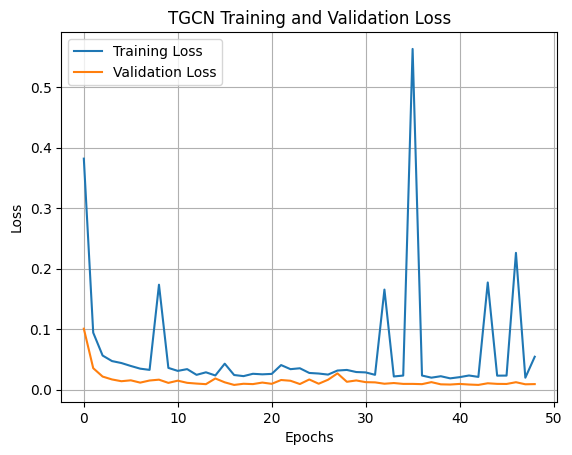

In [60]:
#alculate class weights for the loss fct
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_counts = np.bincount(y_train)
class_weights = {0: len(y_train) / (2 * class_counts[0]), 1: len(y_train) / (2 * class_counts[1])}
weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float).to(device)


#loss fct
criterion = torch.nn.CrossEntropyLoss(weight=weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#call the model
model = TGCNModel(in_channels=15, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)


start_time3 = time.time()
#training function
def train(model, optimizer, criterion, train_snapshots, val_snapshots):
    model.train()
    h = None
    train_loss = 0

    for snapshot in train_snapshots:
        x, edge_index, edge_weight, y = snapshot
        x, edge_index, edge_weight, y = x.to(device), edge_index.to(device), edge_weight.to(device), y.to(device).long()

        optimizer.zero_grad()
        y_hat, h = model(x, edge_index, edge_weight, h)
        h = h.detach()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    h = None
    val_loss = 0

    with torch.no_grad():
        for snapshot in val_snapshots:
            x, edge_index, edge_weight, y = snapshot
            x, edge_index, edge_weight, y = x.to(device), edge_index.to(device), edge_weight.to(device), y.to(device).long()

            y_hat, h = model(x, edge_index, edge_weight, h)
            loss = criterion(y_hat, y)
            val_loss += loss.item()

    return train_loss / len(train_snapshots), val_loss / len(val_snapshots)

#training loop
loss_train4 = []
val_loss_train4 = []

for epoch in range(1, 50):
    train_loss, val_loss = train(model, optimizer, criterion, train_snapshots, test_snapshots)
    loss_train4.append(train_loss)
    val_loss_train4.append(val_loss)
    print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


#test fct for accuracy
def test(model, test_snapshots, threshold=0.5):
    model.eval()
    h = None
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for snapshot in test_snapshots:
            x, edge_index, edge_weight, y = snapshot
            x, edge_index, edge_weight, y = x.to(device), edge_index.to(device), edge_weight.to(device), y.to(device).long()

            y_hat, h = model(x, edge_index, edge_weight, h)
            probs = torch.softmax(y_hat, dim=1)[:, 1]  # Get the probability of the positive class
            preds = (probs > threshold).long()  # Apply threshold
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc


#precision recall fct
def precision_recall(model, test_snapshots, threshold=0.5):
    model.eval()
    h = None
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for snapshot in test_snapshots:
            x, edge_index, edge_weight, y = snapshot
            x, edge_index, edge_weight, y = x.to(device), edge_index.to(device), edge_weight.to(device), y.to(device).long()

            y_hat, h = model(x, edge_index, edge_weight, h)
            probs = torch.softmax(y_hat, dim=1)[:, 1]  # Get the probability of the positive class
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    f1 = f1_score(all_labels, np.array(all_probs) > threshold)
    aupr = average_precision_score(all_labels, all_probs)
    return precision, recall, aupr, f1, all_probs, all_labels

end_time3=time.time()

# Plotting the loss
plt.plot(loss_train4, label='Training Loss')
plt.plot(val_loss_train4, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TGCN Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


The accuracy is 0.9927
The F1 Score: 0.8730
The training time is 14.2420 secondes.


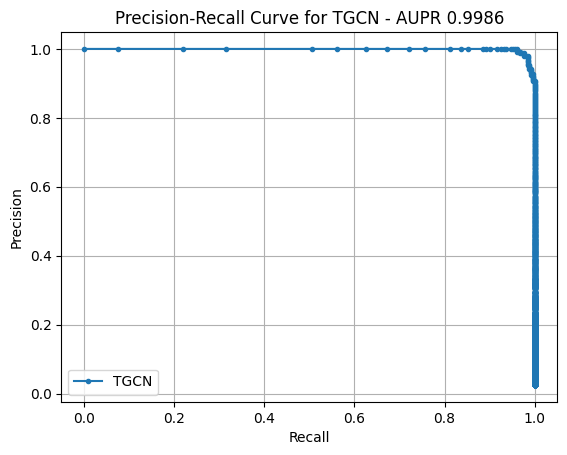

In [61]:
from sklearn.metrics import accuracy_score

precision3, recall3, aupr3, f13, all_probs3, all_labels3 = precision_recall(model, test_snapshots)
accuracy = test(model, test_snapshots)
print(f"The accuracy is {accuracy:.4f}")
print(f"The F1 Score: {f13:.4f}")
print(f"The training time is {end_time3-start_time3:.4f} secondes.")

# Plotting Precision-Recall curve
plt.plot(recall3, precision3, marker='.', label='TGCN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for TGCN - AUPR {aupr3:.4f}')
plt.legend()
plt.grid()
plt.show()


The f1 score is 0.87 which is really good meaning this model right now is the best to predict teh fraudulent class.

### **Comparaison of the models**

We are gonna plot a graph with all the P-R curves and we are going to compare the F1 score with the training time.

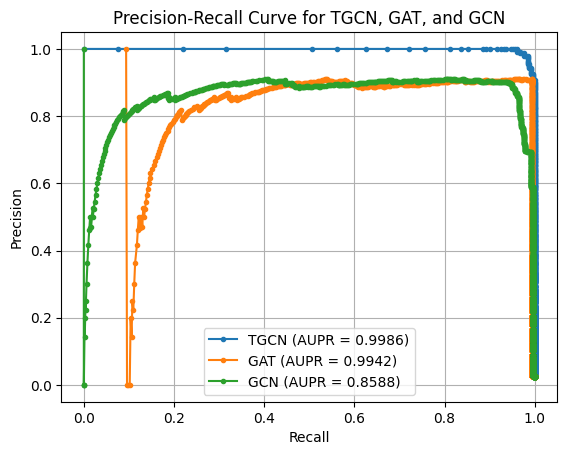

  Model  F1 Score  Training Time (s)
0  TGCN  0.873043          14.242025
1   GAT  0.796997           9.142647
2   GCN  0.412909           6.810639


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

#graph
plt.plot(recall3, precision3, marker='.', label='TGCN (AUPR = {:.4f})'.format(aupr3))
plt.plot(recall2, precision1, marker='.', label='GAT (AUPR = {:.4f})'.format(aupr2))
plt.plot(recall1, precision1, marker='.', label='GCN (AUPR = {:.4f})'.format(aupr1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for TGCN, GAT, and GCN')
plt.legend()
plt.grid()
plt.show()

# F1 scores
f1_scores = {
    'Model': ['TGCN', 'GAT', 'GCN'],
    'F1 Score': [f13, f12, f11]
}

# Training times
training_time = {
    'Training Time (s)': [end_time3 - start_time3, end_time2 - start_time2, end_time1 - start_time1]
}

# Create DataFrame by merging F1 scores and training times
f1_df = pd.DataFrame(f1_scores)
f1_df['Training Time (s)'] = training_time['Training Time (s)']

# Display the table of F1 scores and training times
print(f1_df)



To evaluate the performance of T-GCN, GAT, and GCN models on the task of dynamic graph-based fraud detection, we analyzed both their classification effectiveness and computational efficiency.

The T-GCN model demonstrated the strongest performance, achieving the highest Area Under the Precision-Recall Curve (AUPR) of 0.9986 and an F1 Score of 0.873, indicating excellent precision and recall across various thresholds. Although its training time (14.24 seconds) was slightly higher than the others.

GAT performed competitively with an AUPR of 0.9942 and an F1 Score of 0.797, striking a reasonable balance between accuracy and training efficiency (9.14 seconds).

In contrast, GCN, while being the fastest model to train (6.81 seconds), significantly lagged behind in predictive performance, achieving only 0.8588 AUPR and 0.4129 F1 Score. This suggests that GCN is less capable of capturing the temporal and structural complexity inherent in the dataset.

Overall, T-GCN emerges as the most reliable and effective model for high-stakes applications such as fraud detection, where accurately identifying rare fraudulent events is critical.